In [17]:
import os
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio

import keras
import tensorflow as tf

NUM_REALIZATIONS = 929
NX,  NY,  NZ = 64, 64, 1
NTT, NT1, NT2 = 40, 20, 5
HIDDEN = [16, 64, 256]

sec2year   = 365.25 * 24 * 60 * 60
Darcy      = 9.869233e-13
psi2pascal = 6894.76
co2_rho    = 686.5266
milli      = 1e-3
mega       = 1e6

In [18]:
def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    kversion = keras.__version__
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*62)
    print('------------------------ VERSION INFO ------------------------')
    print('TF version: {} | Keras: {} | # Device(s) available: {}'.format(version, kversion, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[-1])
    print('-'*62+'\n')
    return None

check_tf_gpu()

--------------------------------------------------------------
------------------------ VERSION INFO ------------------------
TF version: 2.15.0 | Keras: 3.5.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
--------------------------------------------------------------



In [19]:
deltatime = sio.loadmat('simulations/data/time_arr.mat', simplify_cells=True)['time_arr']
timesteps = np.cumsum(deltatime)
timesteps_inj = timesteps[:20]
timesteps_mon = timesteps[[21, 24, 29, 34, 39]]

print('timesteps: {} | deltatime: {}'.format(len(timesteps), np.unique(deltatime)))
print('injection: {}'.format(timesteps_inj))
print('monitoring: {}'.format(timesteps_mon))

timesteps: 40 | deltatime: [ 0.5 50. ]
injection: [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
monitoring: [ 110.  260.  510.  760. 1010.]


In [20]:
# Load data
X_data = np.load('simulations/data/X_data.npy')
c_data = np.load('simulations/data/c_data.npy')
y1_data = np.load('simulations/data/y1_data.npy')
y2_data = np.load('simulations/data/y2_data.npy')[:,[1, 4, 9, 14, 19]]
print('X: {} | c: {}'.format(X_data.shape, c_data.shape))
print('y1: {} | y2: {}'.format(y1_data.shape, y2_data.shape))

# Normalize data
pmu, psd = X_data[...,0].mean(), X_data[...,0].std() # porosity
kmu, ksd = X_data[...,1].mean(), X_data[...,1].std() # permeability
wmi, wma = X_data[...,2].min(),  X_data[...,2].max() # wells
tmi, tma = X_data[...,3].min(),  X_data[...,3].max() # tops
vmi, vma = X_data[...,4].min(),  X_data[...,4].max() # volumes
cmi, cma = c_data.min(),         c_data.max()        # controls

X_data[...,0] = (X_data[...,0] - pmu) / (3.33*psd)
X_data[...,1] = (X_data[...,1] - kmu) / (3.33*ksd)
X_data[...,2] = (X_data[...,2] - wmi) / (wma - wmi)
X_data[...,3] = (X_data[...,3] - tmi) / (tma - tmi)
X_data[...,4] = (X_data[...,4] - vmi) / (vma - vmi)
c_data = c_data / 2.0

y1_data[...,0]  = y1_data[...,0]  / 50e3
y1_data[...,-1] = y1_data[...,-1] / 0.73
y2_data[...,-1] = y2_data[...,-1] / 0.73

print('porosity     - min: {:.2f} | max: {:.2f}'.format(X_data[...,0].min(), X_data[...,0].max()))
print('logperm      - min: {:.2f} | max: {:.2f}'.format(X_data[...,1].min(), X_data[...,1].max()))
print('wells        - min: {:.2f} | max: {:.2f}'.format(X_data[...,2].min(), X_data[...,2].max()))
print('tops         - min: {:.2f} | max: {:.2f}'.format(X_data[...,3].min(), X_data[...,3].max()))
print('volumes      - min: {:.2f} | max: {:.2f}'.format(X_data[...,4].min(), X_data[...,4].max()))
print('controls     - min: {:.2f} | max: {:.2f}'.format(c_data.min(),        c_data.max()))
print('pressure_1   - min: {:.2f} | max: {:.2f}'.format(y1_data[...,0].min(), y1_data[...,0].max()))
print('saturation_1 - min: {:.2f} | max: {:.2f}'.format(y1_data[...,-1].min(), y2_data[...,-1].max()))
print('saturation_2 - min: {:.2f} | max: {:.2f}'.format(y2_data[...,-1].min(), y2_data[...,-1].max()))

X: (929, 64, 64, 5) | c: (929, 20, 5)
y1: (929, 20, 64, 64, 2) | y2: (929, 5, 64, 64, 1)
porosity     - min: -0.62 | max: 2.35
logperm      - min: -2.19 | max: 2.48
wells        - min: 0.00 | max: 1.00
tops         - min: 0.00 | max: 1.00
volumes      - min: 0.00 | max: 1.00
controls     - min: 0.00 | max: 0.83
pressure_1   - min: 0.08 | max: 0.91
saturation_1 - min: 0.00 | max: 0.93
saturation_2 - min: 0.00 | max: 0.93


In [21]:
train_idx = np.load('models/training_idx.npy')
test_idx  = np.setdiff1d(range(len(X_data)), train_idx)

X_train = X_data[train_idx].astype(np.float32)
c_train = c_data[train_idx].astype(np.float32)
y1_train = y1_data[train_idx].astype(np.float32)
y2_train = y2_data[train_idx].astype(np.float32)
X_test = X_data[test_idx].astype(np.float32)
c_test = c_data[test_idx].astype(np.float32)
y1_test = y1_data[test_idx].astype(np.float32)
y2_test = y2_data[test_idx].astype(np.float32)

print('X_train:  {}     | c_train: {}'.format(X_train.shape, c_train.shape))
print('y1_train: {} | y2_train: {}'.format(y1_train.shape, y2_train.shape))
print('-'*70)
print('X_test:  {}     | c_test: {}'.format(X_test.shape, c_test.shape))
print('y1_test: {} | y2_test: {}'.format(y1_test.shape, y2_test.shape))

X_train:  (800, 64, 64, 5)     | c_train: (800, 20, 5)
y1_train: (800, 20, 64, 64, 2) | y2_train: (800, 5, 64, 64, 1)
----------------------------------------------------------------------
X_test:  (129, 64, 64, 5)     | c_test: (129, 20, 5)
y1_test: (129, 20, 64, 64, 2) | y2_test: (129, 5, 64, 64, 1)


***
### INFERENCE

In [22]:
from pix2vid2 import make_model

In [23]:
model = make_model(hidden=HIDDEN)
model.load_weights('models/pix2vid-v2.weights.h5')

# parameters: 99,917,310


In [29]:
xtrain = tf.cast(X_train, tf.float32)
ctrain = tf.cast(c_train, tf.float32)
y1train = tf.cast(y1_train, tf.float32)
y2train = tf.cast(y2_train, tf.float32)

xtest = tf.cast(X_test, tf.float32)
ctest = tf.cast(c_test, tf.float32)
y1test = tf.cast(y1_test, tf.float32)
y2test = tf.cast(y2_test, tf.float32)

y1train_pred, y2train_pred = model.predict([xtrain, ctrain], verbose=False)
y1train_pred, y2train_pred = np.array(y1train_pred), np.array(y2train_pred)
print('y1train_pred: {} | y2train_pred: {}'.format(y1train_pred.shape, y2train_pred.shape))

y1test_pred, y2test_pred = model.predict([xtest, ctest], verbose=False)
y1test_pred, y2test_pred = np.array(y1test_pred), np.array(y2test_pred)
print('y1test_pred:  {} | y2test_pred:  {}'.format(y1test_pred.shape, y2test_pred.shape))

y1train, y1test = y1train.numpy(), y1test.numpy()
y2train, y2test = y2train.numpy(), y2test.numpy()

y1train_pred: (800, 20, 64, 64, 2) | y2train_pred: (800, 5, 64, 64, 1)
y1test_pred:  (129, 20, 64, 64, 2) | y2test_pred:  (129, 5, 64, 64, 1)


In [93]:
metrics_train = pd.DataFrame(np.zeros((3,3)), index=['mse','ssim','psnr'], columns=['p1','s1','s2'])
metrics_train.loc['mse','p1'] = np.mean([mean_squared_error(y1train[:,j,...,0], y1train_pred[:,j,...,0]) for j in range(NT1)])
metrics_train.loc['mse','s1'] = np.mean([mean_squared_error(y1train[:,j,...,-1], y1train_pred[:,j,...,-1]) for j in range(NT1)])
metrics_train.loc['mse','s2'] = np.mean([mean_squared_error(y2train[:,j,...,-1], y2train_pred[:,j,...,-1]) for j in range(NT2)])
metrics_train.loc['ssim','p1'] = np.mean([structural_similarity(y1train[:,j,...,0], y1train_pred[:,j,...,0], channel_axis=-1, data_range=1.0) for j in range(NT1)])
metrics_train.loc['ssim','s1'] = np.mean([structural_similarity(y1train[:,j,...,-1], y1train_pred[:,j,...,-1], channel_axis=-1, data_range=1.0) for j in range(NT1)])
metrics_train.loc['ssim','s2'] = np.mean([structural_similarity(y2train[:,j,...,-1], y2train_pred[:,j,...,-1], channel_axis=-1, data_range=1.0) for j in range(NT2)])
metrics_train.loc['psnr','p1'] = np.mean([peak_signal_noise_ratio(y1train[:,j,...,0], y1train_pred[:,j,...,0], data_range=1.0) for j in range(NT1)])
metrics_train.loc['psnr','s1'] = np.mean([peak_signal_noise_ratio(y1train[:,j,...,-1], y1train_pred[:,j,...,-1], data_range=1.0) for j in range(NT1)])
metrics_train.loc['psnr','s2'] = np.mean([peak_signal_noise_ratio(y2train[:,j,...,-1], y2train_pred[:,j,...,-1], data_range=1.0) for j in range(NT2)])

metrics_train

,p1,s1,s2
mse,0.000026,0.000562,0.000766
ssim,0.992262,0.980961,0.976844
psnr,46.267899,39.264884,31.180312


In [94]:
metrics_test = pd.DataFrame(np.zeros((3,3)), index=['mse','ssim','psnr'], columns=['p1','s1','s2'])
metrics_test.loc['mse','p1'] = np.mean([mean_squared_error(y1test[:,j,...,0], y1test_pred[:,j,...,0]) for j in range(NT1)])
metrics_test.loc['mse','s1'] = np.mean([mean_squared_error(y1test[:,j,...,-1], y1test_pred[:,j,...,-1]) for j in range(NT1)])
metrics_test.loc['mse','s2'] = np.mean([mean_squared_error(y2test[:,j,...,-1], y2test_pred[:,j,...,-1]) for j in range(NT2)])
metrics_test.loc['ssim','p1'] = np.mean([structural_similarity(y1test[:,j,...,0], y1test_pred[:,j,...,0], channel_axis=-1, data_range=1.0) for j in range(NT1)])
metrics_test.loc['ssim','s1'] = np.mean([structural_similarity(y1test[:,j,...,-1], y1test_pred[:,j,...,-1], channel_axis=-1, data_range=1.0) for j in range(NT1)])
metrics_test.loc['ssim','s2'] = np.mean([structural_similarity(y2test[:,j,...,-1], y2test_pred[:,j,...,-1], channel_axis=-1, data_range=1.0) for j in range(NT2)])
metrics_test.loc['psnr','p1'] = np.mean([peak_signal_noise_ratio(y1test[:,j,...,0], y1test_pred[:,j,...,0], data_range=1.0) for j in range(NT1)])
metrics_test.loc['psnr','s1'] = np.mean([peak_signal_noise_ratio(y1test[:,j,...,-1], y1test_pred[:,j,...,-1], data_range=1.0) for j in range(NT1)])
metrics_test.loc['psnr','s2'] = np.mean([peak_signal_noise_ratio(y2test[:,j,...,-1], y2test_pred[:,j,...,-1], data_range=1.0) for j in range(NT2)])

metrics_test

,p1,s1,s2
mse,0.000071,0.000793,0.002442
ssim,0.978725,0.963538,0.933116
psnr,41.593444,34.537597,26.136129


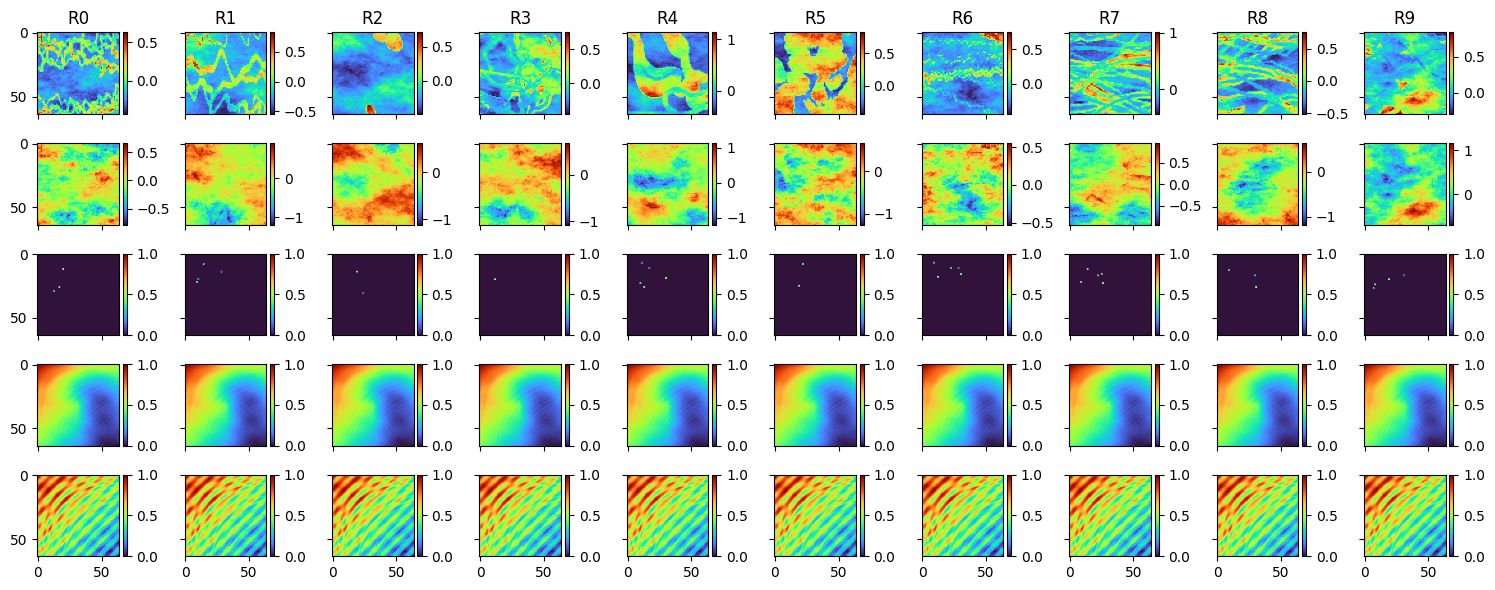

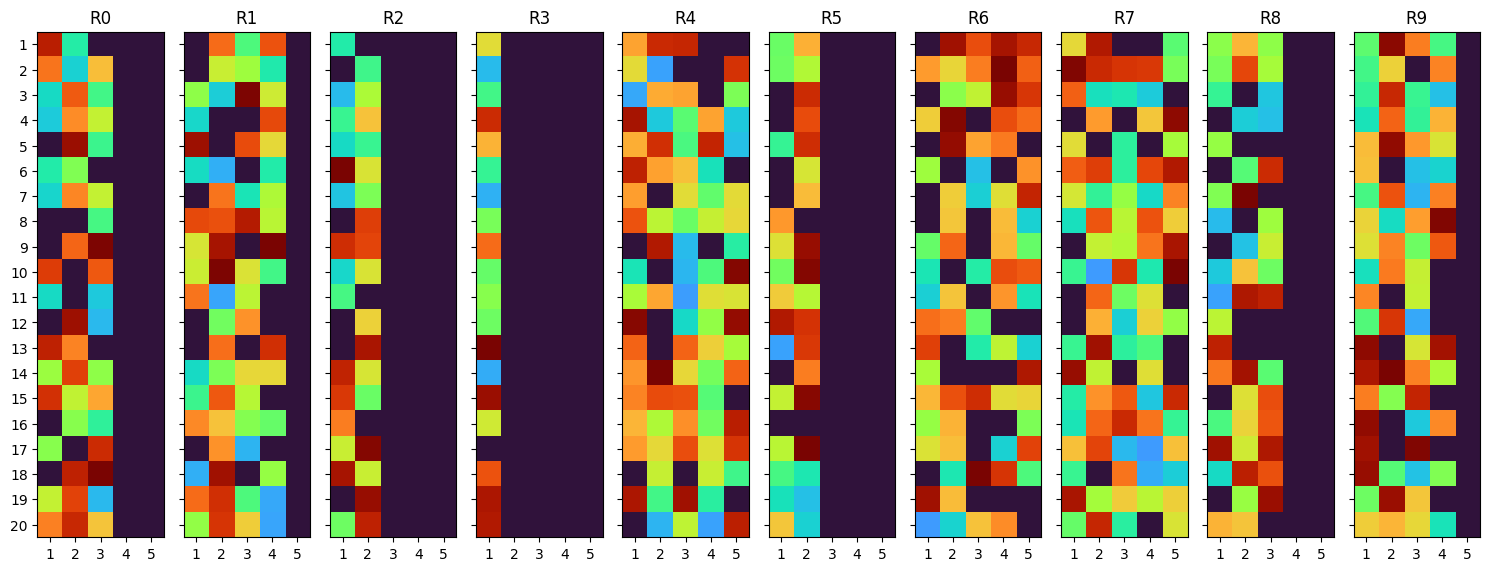

In [14]:
fig, axs = plt.subplots(5, 10, figsize=(15,6), sharex=True, sharey=True)
for i in range(5):
    for j in range(10):
        ax = axs[i,j]
        im = ax.imshow(xtrain[j,...,i], cmap='turbo')
        plt.colorbar(im, pad=0.04, fraction=0.046)
        ax.set_title('R{}'.format(j)) if i == 0 else None
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(15,6), sharex=True, sharey=True)
for j in range(10):
    ax = axs[j]
    im = ax.imshow(ctrain[j], cmap='turbo')
    ax.set_xticks(range(5), labels=np.arange(1,6))
    ax.set_yticks(range(20), labels=np.arange(1,21))
    ax.set(title='R{}'.format(j))
plt.tight_layout()
plt.show()

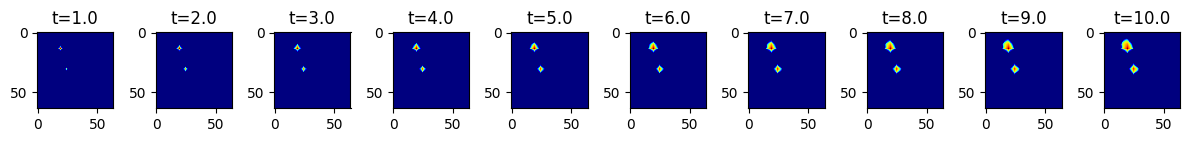

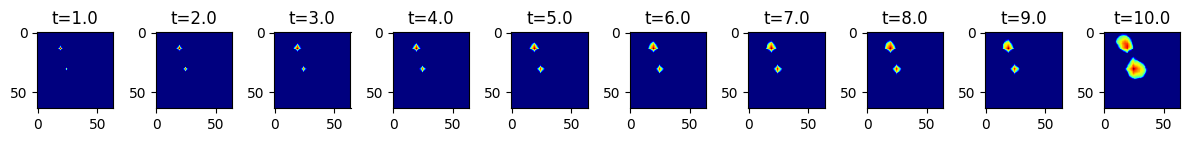

In [15]:
sample = 2

plt.figure(figsize=(12,4))
for j in range(10):
    plt.subplot(1, 10, j+1)
    k = j*2+1
    plt.imshow(y1train[sample, k, ..., -1], 'jet')
    plt.title('t={}'.format(timesteps_inj[k]))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
for j in range(10):
    plt.subplot(1, 10, j+1)
    k = j*2+1
    plt.imshow(y1train_pred[sample, k, ..., -1], 'jet')
    plt.title('t={}'.format(timesteps_inj[k]))
plt.tight_layout()
plt.show()

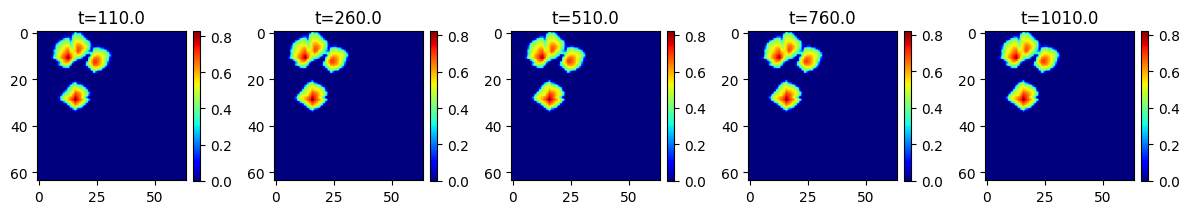

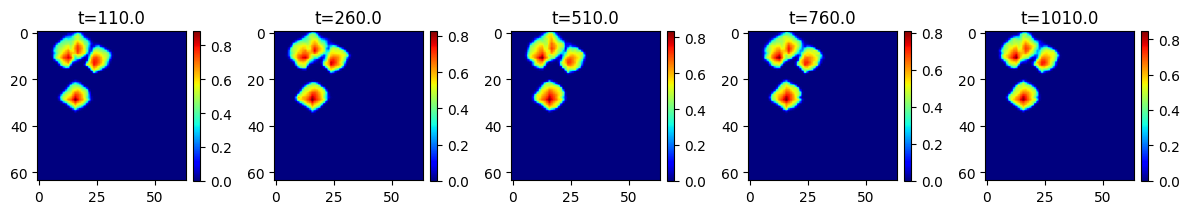

In [16]:
sample = 19

plt.figure(figsize=(12,4))
for j in range(5):
    plt.subplot(1, 5, j+1)
    plt.imshow(y2train[sample, j, ..., -1], 'jet')
    plt.colorbar(pad=0.04, fraction=0.046)
    plt.title('t={}'.format(timesteps_mon[j]))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
for j in range(5):
    plt.subplot(1, 5, j+1)
    plt.imshow(y2train_pred[sample, j, ..., -1], 'jet')
    plt.colorbar(pad=0.04, fraction=0.046)
    plt.title('t={}'.format(timesteps_mon[j]))
plt.tight_layout()
plt.show()

***
# END